<a href="https://colab.research.google.com/github/apalmk/pfizer_task/blob/master/Pfizer_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pfizer Task

###Question 1

In [1]:
#Loading the required libraries
#load drive
from google.colab import drive
import pandas as pd
from datetime import datetime
drive.mount('/content/gdrive')
import statistics
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Activation

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


##Question 1 - Data loading

In [0]:
#Loading the data from the drug adminstration date table
df = pd.read_csv('/content/gdrive/My Drive/drug_admin_date1.csv')

#Loading the data from the drug test flags table
drug_flag = pd.read_csv('/content/gdrive/My Drive/drug_flags.csv')

### Question 1 
A. We find the treatment time for each patient by subtracting the first time he was given the drug from the last time he was given the drug.

In [0]:
#Finding the length of treatment for each patient 
dicti=df.groupby('Patient_ID')['Drug_admin_date'].apply(lambda x: x.tolist()).to_dict()

In [5]:
#Initializing the patient and treatment length dicitonary
dicti1={}
for i in dicti.keys():
  li=[]
  for j in dicti[i]:
    li.append(datetime.strptime(j, '%m/%d/%y'))
  dicti1[i]=li

dicti2={}
for i in dicti1.keys():
  dicti2[i]=(max(dicti1[i])-min(dicti1[i])).days

print("Patients that have treatment time as 0 are:")
#for 3 patients with the following IDs we have the treatment time as 0, as the drug was administered only once to them
#The IDs of those patients are
for i in dicti2.keys():
  if dicti2[i]==0:
    print(i)

Patients that have treatment time as 0 are:
2634
6837
6922


The patients with IDs given above had only one date associated with them, maybe because the drug was administered only once to them. To such patients the treatment time is taken as 0.

In [0]:
#Converting the dicitonary into a dataframe
df1=pd.DataFrame(dicti2.items(), columns=["Patient_ID","treatment_len_days"])

In [7]:
df1.head()

,Patient_ID,treatment_len_days
0,2038,56
1,2120,3002
2,2175,3019
3,2407,2140
4,2425,1986


In [0]:
#Merging the normal dataframe with the treatment times
fin_df=pd.merge(df1, drug_flag, on='Patient_ID', how='inner')

In [10]:
fin_df.head()

,Patient_ID,treatment_len_days,drug_390_admin_flag,ER_positive,PR_positive,HER2_positive
0,2038,56,1,1,1,0
1,2120,3002,0,1,0,1
2,2175,3019,0,0,0,0
3,2407,2140,0,0,1,0
4,2425,1986,1,0,0,0


HR is positive if either of ER or PR are positive, it is negative otherwise.

In [0]:
#Adding HR column
fin_df["HR_positive"]=fin_df["ER_positive"] | fin_df["PR_positive"]

In [0]:
#Adding a new column called category to identify the category of patient based on HR/HER2
ll=[]
for row in fin_df.itertuples(index=False):
  d=row._asdict()
  if d["HER2_positive"] == 0 and d["HR_positive"]==0:
    ll.append('A')
  elif d["HER2_positive"] == 0 and d["HR_positive"]==1:
    ll.append('B')
  elif d["HER2_positive"] == 1 and d["HR_positive"]==0:
    ll.append('C')
  else:
    ll.append('D')

fin_df["category"]= ll

In [13]:
fin_df.head()

,Patient_ID,treatment_len_days,drug_390_admin_flag,ER_positive,PR_positive,HER2_positive,HR_positive,category
0,2038,56,1,1,1,0,1,B
1,2120,3002,0,1,0,1,1,D
2,2175,3019,0,0,0,0,0,A
3,2407,2140,0,0,1,0,1,B
4,2425,1986,1,0,0,0,0,A


### How I defined each category



\begin{array}{ccc}
\text{HER2_status}&\text{HR_status}&\text{Category}\\
0&0&A\\
0&1&B\\
1&0&C\\
1&1&D
\end{array}

### Question 1 
B. Comparing the length of treatment of patients of Drug 390 v/s generic

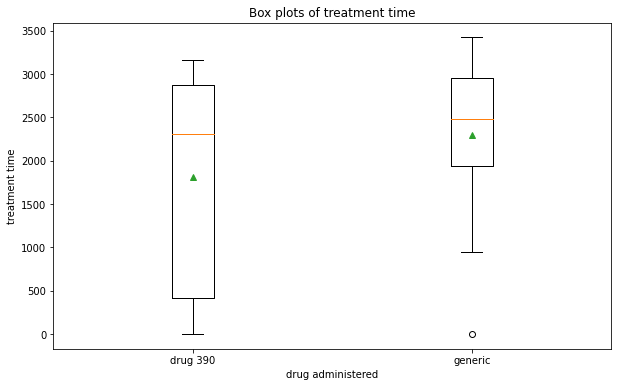

In [15]:

fl = fin_df['drug_390_admin_flag'] == 1

data_to_plot = [fin_df[fl]['treatment_len_days'], fin_df[~fl]['treatment_len_days']]

plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions=[1, 2],
                  labels=['drug 390','generic'], showmeans=True)

plt.title('Box plots of treatment time')
plt.xlabel('drug administered')
plt.ylabel('treatment time');

* We can see that the spread or range is more for the patients that took our drug 390. This means that treatment time varied more for the people that were administered our drug compared to the ones that were administered the generic one. 


* The median no of days it takes for the treatment is almost the same for both the drugs.


* The upper and lower whisker of the drug 390 are lower than the generic, this means that the largest and the smallest treatment time is smaller in the people that took the drug 390. 


* We can see that the treatment time of 0 was considered as an outlier for the people that were administered the generic drug, this is because there are not many treatment times close to 0 for the people that were given the generic drug. (It lies under lower_whisker - 1.5 x IQR)

* Eventhough nearly half of the people in the both cases had a treatment time of 2300 days or less, the people that were given drug 390 had smaller treatment times than their counter parts in some of the cases.

In [16]:
#medians of both the groups
print("People that were administered Drug 390 had a median treatment time of: ",statistics.median(fin_df[fl]['treatment_len_days']))

print("People that were administered the generic drug had a median treatment time of: ",statistics.median(fin_df[~fl]['treatment_len_days']))

People that were administered Drug 390 had a median treatment time of:  2306.5
People that were administered the generic drug had a median treatment time of:  2483


### Question 1
C. Comparing the length of treatment of patients of Drug 390 v/s generic by category

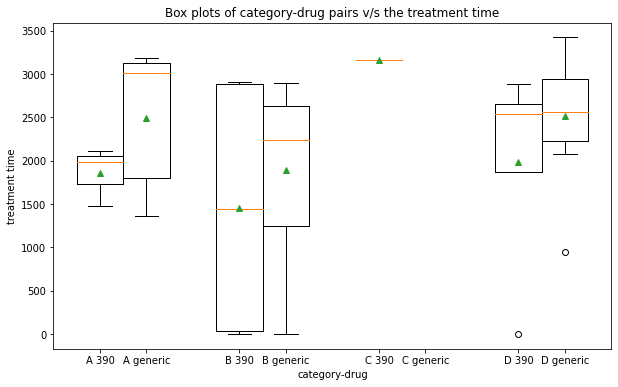

In [52]:
la_390=[]
la=[]
lb_390=[]
lb=[]
lc_390=[]
lc=[]
ld_390=[]
ld=[]
for row in fin_df.itertuples(index=False):
  d=row._asdict()
  if d["category"] == 'A' and d["drug_390_admin_flag"]==1:
    la_390.append(d["treatment_len_days"])
  if d["category"] == 'A' and d["drug_390_admin_flag"]==0:
    la.append(d["treatment_len_days"])
  if d["category"] == 'B' and d["drug_390_admin_flag"]==1:
    lb_390.append(d["treatment_len_days"])
  if d["category"] == 'B' and d["drug_390_admin_flag"]==0:
    lb.append(d["treatment_len_days"])
  if d["category"]=='C' and d["drug_390_admin_flag"]==1:
    lc_390.append(d["treatment_len_days"])
  if d["category"]=='C' and d["drug_390_admin_flag"]==0:
    lc.append(d["treatment_len_days"])
  if d["category"]=='D' and d["drug_390_admin_flag"]==1:
    ld_390.append(d["treatment_len_days"])
  if d["category"]=='D' and d["drug_390_admin_flag"]==0:
    ld.append(d["treatment_len_days"])

data_to_plot = [la_390, la,
                lb_390, lb,
                lc_390, lc,
                ld_390, ld]

plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions=[1, 1.5, 2.5, 3, 4, 4.5, 5.5, 6],
                  labels=['A 390','A generic','B 390','B generic','C 390','C generic','D 390','D generic'], showmeans=True)

plt.title('Box plots of category-drug pairs v/s the treatment time')
plt.xlabel('category-drug')
plt.ylabel('treatment time');




*   We can see that for the category A (HER2 negative and HR negative) the drug 390 has smaller treatment time in general, and there is a lot of difference in the median treatment times.

*   The same goes for the category B (HER2 negative, HR positive), we also see that the distribution is symmetric around the median in the case of drug 390. We can also see that the largest and the smallest treatment times are equal for both drug 390 and generic drug recepients.

*   In the case of C (HER2 positive, HR negative), we only have one data point (only one patient). This patient was adiministered the drug 390.


*   We can see that there are only 4 points (patients) associated with the drug 390 that belonged to the category D (that is why the smallest point is inside the lower quartile). The medians are comparable in both the cases and there are outliers in both the cases. 

*   Note: The green triangles show the means.







### Let us see why the plots for categories 'C' and 'D' look like this 

In [38]:
grp=fin_df[['Patient_ID','treatment_len_days','category','drug_390_admin_flag']].groupby(["category","drug_390_admin_flag"])

for g in grp:
  print(g)

(('A', 0),     Patient_ID  treatment_len_days category  drug_390_admin_flag
2         2175                3019        A                    0
5         2462                1797        A                    0
30        7937                1365        A                    0
31        7976                3186        A                    0
32        8480                3125        A                    0)
(('A', 1),     Patient_ID  treatment_len_days category  drug_390_admin_flag
4         2425                1986        A                    1
21        6321                2115        A                    1
27        7230                1479        A                    1)
(('B', 0),     Patient_ID  treatment_len_days category  drug_390_admin_flag
3         2407                2140        B                    0
6         2634                   0        B                    0
9         2770                1323        B                    0
11        3449                2892        B            

###This happened because of imbalenced distribution of data into categories

There were no patients in category C that were given generic drug, and there was only one patient that was given the drug 390. Overall there was only one patient in category C(HER status 1, HR status 0).
There are only 4 patients in category D that were given the drug 390, and one of them is an outlier (0 treatment days). 

### Question 1
D. The treatment time will be a compelling target to predict from this dataset. 

With a new patient we can first identify his/her HER2 status, ER status and PR status, and then make two samples, one in which we give him the generic drug (drug 390 flag = 0), and another in which we give him the drug 390 (drug 390 flag = 1). Then we can use our trained model to predict the treatment time for these two samples.

Using this prediction we can decide if we should go with the drug 390 or the generic drug for this patient. Other features about the patients such as the age etc, might also affect the treatment time and inturn help us make better predicitions.


## Question 2 - Data loading and pre-processing

In [0]:
#importing the data
data = pd.read_csv('/content/gdrive/My Drive/heart_data.csv')

In [18]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [19]:
#Checking if the dataset is balanced
print("No of positive samples are: ",list(data["target"]).count(1))
print("No of negative samples are: ",list(data["target"]).count(0))

No of positive samples are:  165
No of negative samples are:  138


We can see that the dataset is not very imbalenced and we can thus use accuracy as our performance metric.

Let us now check if there is any missing data in any columns

In [61]:
#missing data in each column
print(data.isnull().sum(axis = 0))

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


There seems to be no missing data.

In [63]:
#Checking if there is any data outside 3 standard deviations of a standard normal
set(list((np.abs(stats.zscore(data)) < 3).all(axis=1)))

{False, True}

There are outliers in the data, but we will not be removing them, as this data is from actual samples and the outliers might not have been a mistake in the recording.

### Plotting all variables against the target

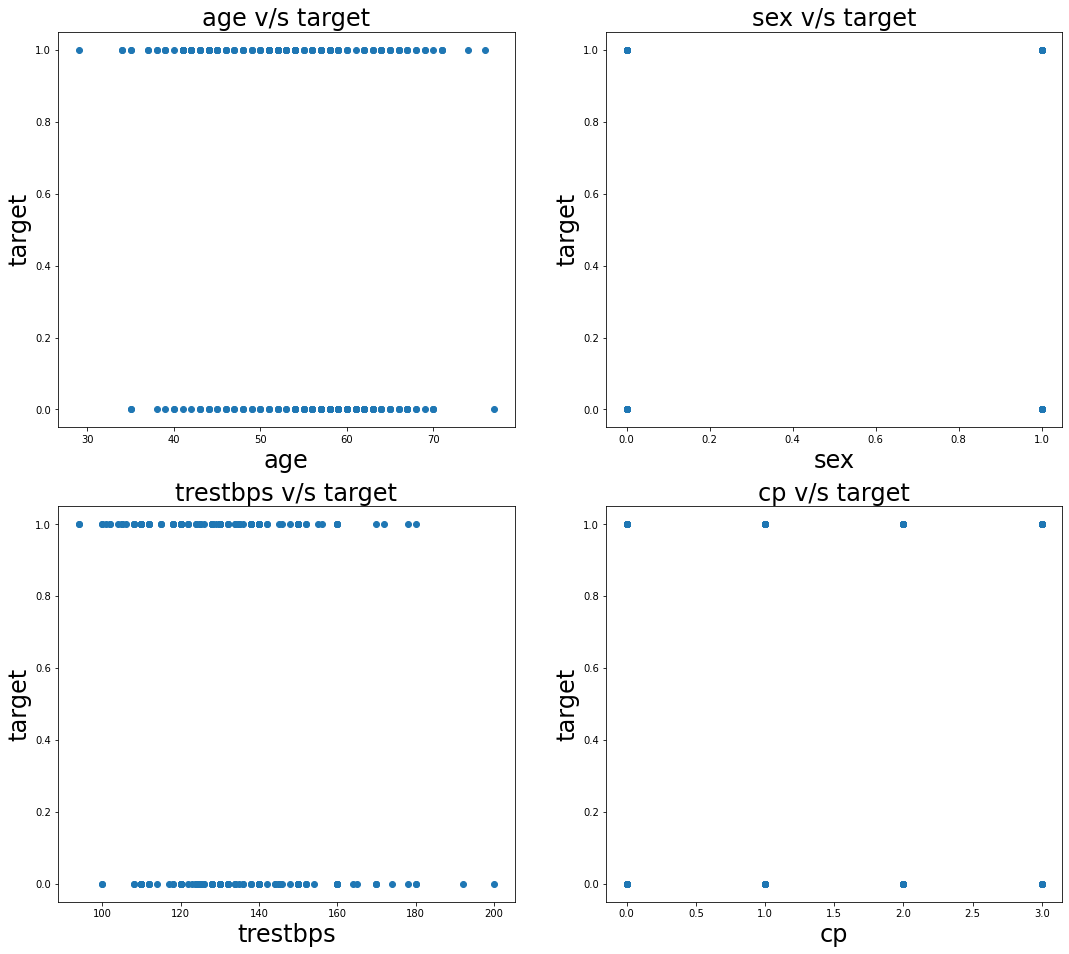

In [65]:
#plots of covariates with the binary target variable


fig, axes = plt.subplots(2, 2, figsize=(18,16))
axes[0, 0].scatter(data['age'],data['target'])
axes[0,0].set_title("age v/s target",fontsize=24)
axes[0,0].set_xlabel("age",fontsize=24)
axes[0,0].set_ylabel("target",fontsize=24)

axes[0, 1].scatter(data['sex'],data['target'])
axes[0,1].set_title("sex v/s target",fontsize=24)
axes[0,1].set_xlabel("sex",fontsize=24)
axes[0,1].set_ylabel("target",fontsize=24)

axes[1, 0].scatter(data['trestbps'],data['target'])
axes[1,0].set_title("trestbps v/s target",fontsize=24)
axes[1,0].set_xlabel("trestbps",fontsize=24)
axes[1,0].set_ylabel("target",fontsize=24)


axes[1, 1].scatter(data['cp'],data['target'])
axes[1,1].set_title("cp v/s target",fontsize=24)
axes[1,1].set_xlabel("cp",fontsize=24)
axes[1,1].set_ylabel("target",fontsize=24);

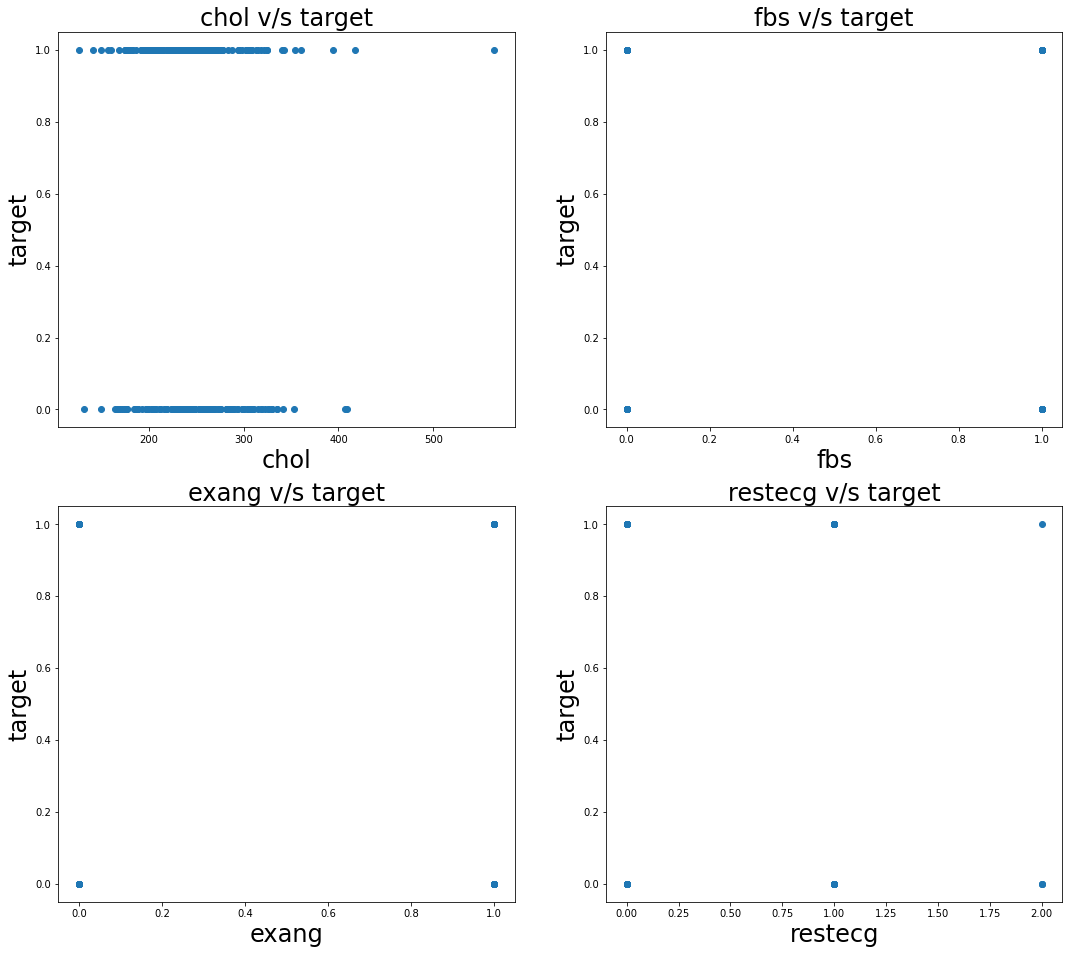

In [66]:
#plots of covariates with the binary target variable


fig, axes = plt.subplots(2, 2, figsize=(18,16))
axes[0, 0].scatter(data['chol'],data['target'])
axes[0,0].set_title("chol v/s target",fontsize=24)
axes[0,0].set_xlabel("chol",fontsize=24)
axes[0,0].set_ylabel("target",fontsize=24)

axes[0, 1].scatter(data['fbs'],data['target'])
axes[0,1].set_title("fbs v/s target",fontsize=24)
axes[0,1].set_xlabel("fbs",fontsize=24)
axes[0,1].set_ylabel("target",fontsize=24)

axes[1, 0].scatter(data['exang'],data['target'])
axes[1,0].set_title("exang v/s target",fontsize=24)
axes[1,0].set_xlabel("exang",fontsize=24)
axes[1,0].set_ylabel("target",fontsize=24)


axes[1, 1].scatter(data['restecg'],data['target'])
axes[1,1].set_title("restecg v/s target",fontsize=24)
axes[1,1].set_xlabel("restecg",fontsize=24)
axes[1,1].set_ylabel("target",fontsize=24);

In [67]:
data[data["chol"]>450]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1


One interesting observation we made from this plot is that there is only one point with cholestrol value greater than 450 and this person had the heart disease. 

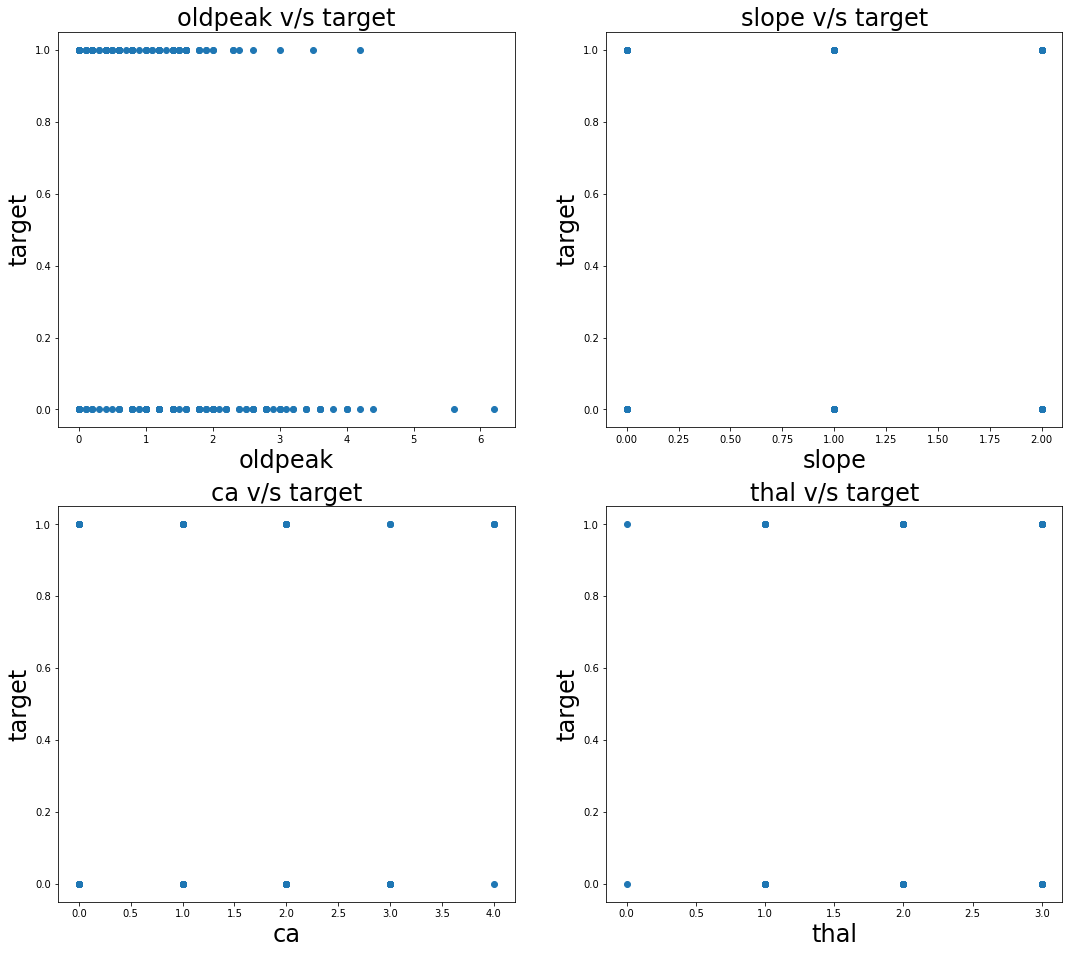

In [68]:
#plots of covariates with the binary target variable


fig, axes = plt.subplots(2, 2, figsize=(18,16))
axes[0, 0].scatter(data['oldpeak'],data['target'])
axes[0,0].set_title("oldpeak v/s target",fontsize=24)
axes[0,0].set_xlabel("oldpeak",fontsize=24)
axes[0,0].set_ylabel("target",fontsize=24)

axes[0, 1].scatter(data['slope'],data['target'])
axes[0,1].set_title("slope v/s target",fontsize=24)
axes[0,1].set_xlabel("slope",fontsize=24)
axes[0,1].set_ylabel("target",fontsize=24)

axes[1, 0].scatter(data['ca'],data['target'])
axes[1,0].set_title("ca v/s target",fontsize=24)
axes[1,0].set_xlabel("ca",fontsize=24)
axes[1,0].set_ylabel("target",fontsize=24)


axes[1, 1].scatter(data['thal'],data['target'])
axes[1,1].set_title("thal v/s target",fontsize=24)
axes[1,1].set_xlabel("thal",fontsize=24)
axes[1,1].set_ylabel("target",fontsize=24);

In [69]:
data[data["oldpeak"]>5]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0


One other interesting thing we observed here is that there are only 2 values that had old peak > 5, and both of them are negative samples.

### Reason for plotting categorical against categorical (target) and continuous against categorical (target) variables

We wanted to see if the categorical variable is giving away the target for any value it takes. For continuous variables we wanted to see if any threshold of the continuous value is giving away the target. However, this doesn't seems to be the case. 

### Question 2
A. Fitting Logistic Regression and Random Forest Models

In [0]:
#Shuffle the dataset because the data was grouped by the target variable
data = shuffle(data)

#Resetting indices after shuffling
data.reset_index(inplace=True, drop=True)

In [24]:
#splitting the dataset into X and Y (target and the training columns)
y=np.array(pd.DataFrame(data['target'])).ravel()
X= data.loc[:, data.columns != 'target']

#stratify the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)

#Encoding and scaling the data
cat_variables= ["cp","thal"]
cont_variables= ["age","trestbps","chol","oldpeak","thalach"]

cont_preprocessing = make_pipeline(StandardScaler())
cat_preprocessing = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocess = make_column_transformer((cat_preprocessing, cat_variables), (cont_preprocessing,cont_variables), remainder='passthrough')

pipe_grid={}
grid = GridSearchCV(make_pipeline(preprocess,LogisticRegression(n_jobs=-1)),param_grid=pipe_grid,cv=5,scoring="accuracy")
grid.fit(X_train,y_train)

print("Training Score for Simple Logistic Regression Model: ",grid.best_score_)
print("Testing Score for Simple Logistic Regression Model: ", grid.best_estimator_.score(X_test, y_test))


Training Score for Simple Logistic Regression Model:  0.8385204081632652
Testing Score for Simple Logistic Regression Model:  0.819672131147541


### Making a Random Forest classifier

In [25]:
p=make_pipeline(preprocess,RandomForestClassifier(500,n_jobs=-1))
p.fit(X_train,y_train)
print("Testing Score for Random Forest Model: ", p.score(X_test, y_test))

Testing Score for Random Forest Model:  0.819672131147541


### Question 2
B. Getting the feature importances from the random forest classifier

In [0]:
#Using feature importances from random forest model
C=preprocess.fit_transform(X_train)
feature_names=preprocess.named_transformers_['pipeline-1'][0].get_feature_names(cat_variables)
feature_names = np.r_[feature_names, cont_variables,["sex","fbs","restecg","exang","slope","ca"]]

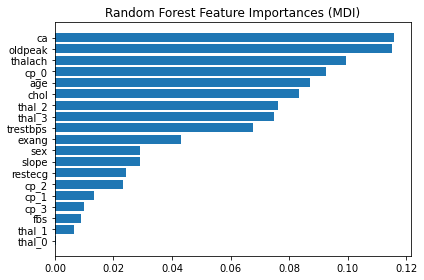

In [215]:
tree_feature_importances = p.named_steps['randomforestclassifier'].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Note: MDI is Mean Decrease in Impurity
From the feature importances of a random forest model we can see that ca (no of major vessels), oldpeak, thalach (maximum heart rate achieved), chest pain of type 0, age and the cholestrol level are a major contributing factors to heart attack.

### Feature Importances from the coefficients of the logistic regression model

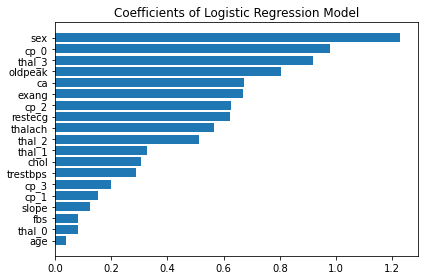

In [244]:
imp=np.abs(grid.best_estimator_.named_steps['logisticregression'].coef_[0])

sorted_idx1 = imp.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, imp[sorted_idx1])
ax.set_yticklabels(feature_names[sorted_idx1])
ax.set_yticks(y_ticks)
ax.set_title("Coefficients of Logistic Regression Model")
fig.tight_layout()
plt.show()

From the coefficients of the logistic regression we can see that sex, chest pain of type 0, thal3, oldpeak, ca, and exang are major contributing factors of heart disease. The important features more or less are the same for both the models.

### Permutation Importances on the test set from both the models

In [0]:
result = permutation_importance(p, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

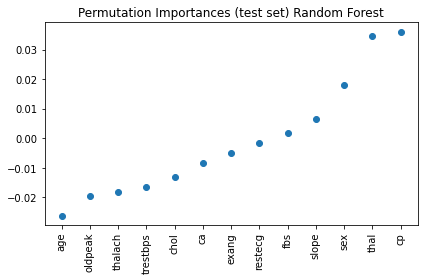

In [256]:
fig, ax = plt.subplots()
ax.scatter(y=result.importances_mean[sorted_idx].T,
            x=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set) Random Forest")
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

From the permutation importances using the random forest model, we see that the cp (chest pain) column (before one hot encoing), thal column (before one hot encoding), sex, slope, fbs and restecg have the highest importance.

In [0]:
result = permutation_importance(grid.best_estimator_, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

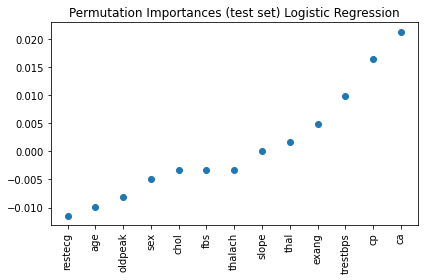

In [259]:
fig, ax = plt.subplots()
ax.scatter(y=result.importances_mean[sorted_idx].T,
            x=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set) Logistic Regression")
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

According to feature importances using logistic regression the features ca, cp, trestbps, exang, thal and slope cause the maximum impact on the target prediction.